In [ ]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

import io
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM

from sklearn.metrics import ConfusionMatrixDisplay, classification_report


In [ ]:
# Import dataset
print("Loading dataset...")
url = "https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv"
spam_df = pd.read_csv(url, encoding='ISO-8859-1')
print("...Done.")
print()

Loading dataset...
...Done.



In [ ]:
# Basic stats
print("Number of rows : {}".format(spam_df.shape[0]))
print()

print("Number of columns : {}".format(spam_df.shape[1]))
print()

print("Display of dataset: ")
display(spam_df.head())
print()

print("Basics statistics: ")
data_desc = spam_df.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*spam_df.isnull().sum()/spam_df.shape[0])

Number of rows : 5572

Number of columns : 5

Display of dataset: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN



Basics statistics: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2



Percentage of missing values: 


v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

In [ ]:
# Drop useless columns (because very high percentages of missing values)
spam_df = spam_df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [ ]:
# We rename the columns
spam_df.rename (columns={"v1":"label", "v2": "text"}, inplace=True)

In [ ]:
spam_df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
spam_df["label"].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [ ]:
print (f"In this dataset {round(spam_df.label.value_counts()[1]/len(spam_df.label)*100,2)}% of text messages are spams.")

In this dataset 13.41% of text messages are spams.


In [ ]:
# We replace label by 1 (spam) or 0 (ham)
spam_df["label"] = spam_df["label"].apply(lambda x:1 if x=="spam" else 0)

In [ ]:
spam_df

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


#Text processing with Spacy


In [ ]:
# We start by downloading spacy for the english language
!python -m spacy download en_core_web_sm -q

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-21 16:29:13.838741: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-21 16:29:13.847490: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-21 16:29:13.847542: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

In [ ]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [ ]:
# Import Stop words 
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
# Remove all non alphanumeric characters except whitespaces
spam_df["text_clean"] = spam_df["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
# remove double spaces and spaces at the beginning and end of strings
spam_df["text_clean"] = spam_df["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())   
# remove stop words and replace everyword with their lemma
spam_df["text_clean"] = spam_df["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

In [ ]:
# We are verifying that there is no empty text after preprocessing.
mask = spam_df.text_clean.apply(lambda x: type(x)==str)
mask.value_counts()

True    5572
Name: text_clean, dtype: int64

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer.fit_on_texts(spam_df.text_clean) # fit the tokenizer on the texts
spam_df["text_encoded"] = tokenizer.texts_to_sequences(spam_df.text_clean)
spam_df["len_text"] = spam_df["text_encoded"].apply(lambda x: len(x)) # we create a column with the length of the text encoded
spam_df = spam_df[spam_df["len_text"]!=0]   #we keep only text with length not null

In [ ]:
# We use "padding" to be sure that all the sequences have the same length.
text_pad = tf.keras.preprocessing.sequence.pad_sequences(spam_df.text_encoded, padding="post")

In [ ]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(text_pad,spam_df.label, test_size=0.3, stratify=spam_df.label) 

In [ ]:
# We create the tensor dataset for the training, and validation set.
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))  
val = tf.data.Dataset.from_tensor_slices((xval, yval))

In [ ]:
# We organise the training and validation sets by batches of 64 observations.
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [ ]:
 # let's vizualise a batch
for review, star in train_batch.take(1):
  print(review, star)

tf.Tensor(
[[ 95 554   1 ...   0   0   0]
 [790   0   0 ...   0   0   0]
 [171   7  23 ...   0   0   0]
 ...
 [401 259   0 ...   0   0   0]
 [171 939   0 ...   0   0   0]
 [  4   8  76 ...   0   0   0]], shape=(64, 54), dtype=int32) tf.Tensor(
[1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0], shape=(64,), dtype=int64)


# A simple Model (model 1)



In [ ]:
# Architecture of the model 1
vocab_size = tokenizer.num_words
model = tf.keras.Sequential([
                  # Input Word Embedding layer           
                  Embedding(vocab_size+1, 8, input_shape=[review.shape[1],],name="embedding"),
                  # Global average pooling layer
                  GlobalAveragePooling1D(),
                  # Dense layer
                  Dense(16, activation='relu'),
                  # Prediction Layer
                  Dense(1, activation="sigmoid")
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 54, 8)             8008      
                                                                 
 global_average_pooling1d_1   (None, 8)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 16)                144       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,169
Trainable params: 8,169
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# We compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Fit the model on epochs
history = model.fit(train_batch, 
                    epochs=30, 
                    validation_data=val_batch,
                    )

Epoch 1/30
59/59 [==============================] - 2s 8ms/step - loss: 0.6291 - accuracy: 0.8620 - val_loss: 0.5642 - val_accuracy: 0.8616
Epoch 2/30
59/59 [==============================] - 0s 4ms/step - loss: 0.4939 - accuracy: 0.8620 - val_loss: 0.4271 - val_accuracy: 0.8616
Epoch 3/30
59/59 [==============================] - 0s 3ms/step - loss: 0.3943 - accuracy: 0.8620 - val_loss: 0.3730 - val_accuracy: 0.8616
Epoch 4/30
59/59 [==============================] - 0s 4ms/step - loss: 0.3665 - accuracy: 0.8620 - val_loss: 0.3611 - val_accuracy: 0.8616
Epoch 5/30
59/59 [==============================] - 0s 3ms/step - loss: 0.3566 - accuracy: 0.8620 - val_loss: 0.3520 - val_accuracy: 0.8616
Epoch 6/30
59/59 [==============================] - 0s 4ms/step - loss: 0.3463 - accuracy: 0.8620 - val_loss: 0.3406 - val_accuracy: 0.8616
Epoch 7/30
59/59 [==============================] - 0s 3ms/step - loss: 0.3326 - accuracy: 0.8620 - val_loss: 0.3238 - val_accuracy: 0.8616
Epoch 8/30
59/59 [==

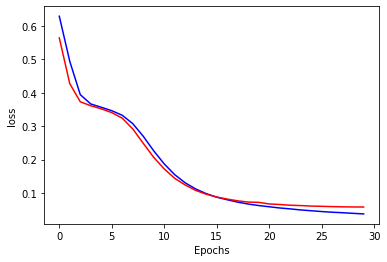

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

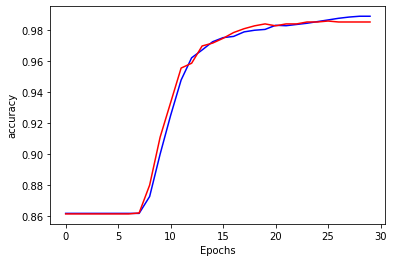

In [ ]:
# Visualization of accuracy training 
plt.plot(history.history["accuracy"], color="b")
plt.plot(history.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

Analysis: 
- We achieved, quickly,  a good performance with a very simple model (accuracy of 97% after only 15 epochs). 
- The model starts overfitting around 20/25 epochs. 
- This simple model works well for the size of our dataset (5572 observations). We should try this model on a much larger dataset to see if it could be generalized.  
